Answer all questions and submit them either as an IPython notebook, LaTeX document, or Markdown document. Each question is worth 25 points.

This homework is due Tuesday, October 24, 2017.

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pymc3 as pm
import seaborn as sns

# Set seed
np.random.seed(42)

# Question 1

Epidemiologists are interested in studying the sexual behavior of individuals at risk for HIV infection. Suppose 1500 gay men were surveyed and each was asked how many risky sexual encounters he had in the previous 30 days. Let $n_i$ denote the number of respondents reporting $i$ encounters, for $i = 1, \ldots , 16$. The DataFrame below contains these reponses:

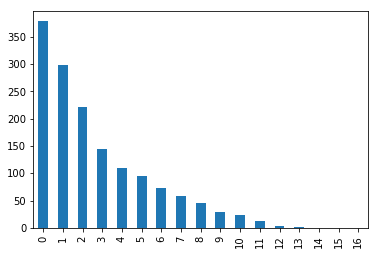

In [2]:
encounters = pd.DataFrame({'count': np.arange(17),
                          'freq': [379, 299, 222, 145, 109, 95, 73, 59,
                                  45, 30, 24, 12, 4, 2, 0, 1, 1]})

encounters.freq.plot.bar()

These data are poorly fitted by a Poisson model. It is more realistic to assume that the respondents comprise three groups. First, there is a group of people who, for whatever reason, report zero risky encounters even if this is not true. Suppose a respondent has probability $\alpha$ of belonging to this group. 

With probability $\beta$, a respondent belongs to a second group representing typical behavior. Such people respond truthfully, and their numbers of risky encounters are assumed to follow a $\text{Poisson}(\mu)$ distribution. 

Finally, with probability $1 − \alpha − \beta$, a respondent belongs to a high-risk group. Such people respond truthfully, and their numbers of risky encounters are assumed to follow a $\text{Poisson}(\lambda)$ distribution. 

The parameters in the model are $\alpha, \beta, \mu$ and $\lambda$. At the $t$th iteration of EM, we use $\theta^{(t)} = (\alpha^{(t)}, \beta^{(t)}, \mu^{(t)}, \lambda^{(t)})$ to denote the current parameter values. The likelihood of the observed data is given by:

$$L(\theta | n_0, \ldots, n_{16}) \propto \prod_{i=0}^{16} \left[ \frac{\pi_i(\theta)}{i!} \right]^{n_i}$$

where $\pi_i(\theta) = \alpha 1_{(i=0)} + \beta \mu^i \exp(-\mu) + (1-\alpha - \beta) \lambda^i \exp(-\lambda)$.

The observed data are in the `encounters` table above; the *complete* data may be construed to be $(n_{z,0}, n_{t,0}, n_{p,0}), \ldots, (n_{z,16}, n_{t,16}, n_{p,16})$, where $k = z, t, p$ correspond to zero, typical and promiscuous groups, respectively. That is, $n_0 = n_{z,0} + n_{t,0} + n_{p,0}$, and so on. Let $N = \sum_{i=0}^{16} n_i = 1500$.

Also define:

$$\begin{align}
z_0(\theta) &=& \frac{\alpha}{\pi_0(\theta)} \\
t_i(\theta) &=& \frac{\beta \mu^i \exp(-\mu)}{\pi_i(\theta)} \\
p_i(\theta) &=& \frac{(1-\alpha-\beta)\lambda^i \exp(-\lambda)}{\pi_i(\theta)}
\end{align}$$

which correspond to probabilities that respondents with $i$ risky encounters belong to various groups.

a. Show that the EM algorithm provides the following updates:

$$\begin{align}
\alpha^{(t+1)} &=& \frac{n_0 z_0(\theta^{(t)})}{N} \\
\beta^{(t+1)} &=& \sum_i \frac{n_i t_i(\theta^{(t)})}{N} \\
\mu^{(t+1)} &=& \frac{\sum_i i n_i t_i(\theta^{(t)})}{\sum_i n_i t_i(\theta^{(t)})} \\
\lambda^{(t+1)} &=& \frac{\sum_i i n_i p_i(\theta^{(t)})}{\sum_i n_i p_i(\theta^{(t)})}
\end{align}$$


b. Extimate the parameters of the model using the observed data.

In [3]:
# Write your answer here
def prob(theta, n):
    alpha, beta, mu, lamb = theta
    nlist = np.arange(n)
    return alpha*(nlist == 0)+beta*np.exp(-mu)*np.power(mu, nlist)+(1-alpha-beta)*np.exp(-lamb)*np.power(lamb, nlist)
    
def e_step(theta, nums):
    alpha, beta, mu, lamb = theta
    n = len(nums)
    nlist = np.arange(n)
    probs = prob(theta, n)
    z_0 = alpha/probs[0]
    t = beta*np.exp(-mu)*np.power(mu, nlist)/probs
    p = (1-alpha-beta)*np.exp(-lamb)*np.power(lamb, nlist)/probs
    return z_0, t, p
    
def m_step(theta, z_0, t, p, nums):
    N = np.sum(nums)
    n = len(nums)
    nlist = np.arange(n)
    alpha = nums[0]*z_0/N
    beta = np.sum(nums*t)/N
    mu = np.sum(nlist*nums*t)/np.sum(nums*t)
    lamb = np.sum(nlist*nums*p)/np.sum(nums*p)
    return [alpha, beta, mu, lamb]

def run_em(theta, data):
    
    # Initialize values
    z_0, t, p = 0.0, 0.0, 0.0
    theta_new = [0.0, 0.0, 0.0, 0.0]

    # Stopping criterion
    crit = 1e-5

    # Convergence flag
    converged = False

    # Loop until converged
    while not converged:

        # E-step
        z_0, t, p = e_step(theta, data)
        # M-step
        theta_new = m_step(theta, z_0, t, p, data)

        # Check convergence
        converged = np.all(np.abs((np.array(theta_new) - np.array(theta))) < crit)
        theta = theta_new

    print('The estimated parameters using EM: alpha {0:.4f}, beta {1:.4f}, mu {2:.4f}, lambda {3:.4f}'
          .format(theta_new[0], theta_new[1], theta_new[2], theta_new[3]))

In [4]:
run_em(theta = [0.1, 0.2, 2, 3], data = np.array(encounters.freq.values))

The estimated parameters using EM: alpha 0.1222, beta 0.5625, mu 1.4674, lambda 5.9388


> Nice work with coding but missing the algebra of the first part:

> 20/25

# Question 2

Suppose $y$ has a binomial distribution with parameters $n$ and $p$, and we are interested in the log-odds value $\theta = \log(p/(1 − p))$. Our prior for $\theta$ is that $\theta \sim N(\mu, \sigma^2)$. It follows that the posterior density of $\theta$ is given, up to a proportionality constant, by:

$$\pi(\theta | y) \propto \frac{\exp(y\theta)}{(1 + exp(\theta))^n} \exp\left[\frac{-(\theta − \mu)^2}{2\sigma^2}\right]$$

For example, suppose we are interested in learning about the probability that a possibly-biased coin lands heads when tossed. *A priori* we believe that the coin is fair, so we assign $\theta$ a $N(0,.25)$ prior. We toss the coin $n = 5$ times and obtain $y = 5$ heads.

1. Using a normal approximation to the posterior density, compute the probability that the coin is biased toward heads (i.e., that θ is positive).
2. Using the prior density as a proposal density, design a rejection algorithm for sampling from the posterior distribution. Using simulated draws from your algorithm, approximate the probability that the coin is biased toward heads.
3. Using the prior density as a proposal density, simulate values from the posterior distribution using the SIR algorithm. Approximate the probability that the coin is biased toward heads.

In [5]:
# Write your anser here
# question 1
from scipy.optimize import minimize
from scipy.stats import distributions

def cal_logposterior(theta, param):
    y = param[0]
    n = param[1]
    mu = param[2]
    sigma = param[3]
    return -1.0*(y*theta - n*np.log(1+np.exp(theta)) - (theta-mu)**2/(2.0*sigma**2))

param = [5, 5, 0, 0.25]

opt = minimize(cal_logposterior, 0, method='L-BFGS-B', args=(param,))
mode = opt.x
var = opt.hess_inv.todense()
# computer the probability above 0
bias_prob1 = 1 - distributions.norm.cdf(0, loc = mode, scale = np.sqrt(var))
bias_prob1[0][0]

0.72640203009638837

0.72136752136752136

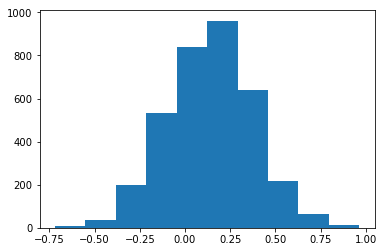

In [6]:
# question 2
def reject(niter):
    theta = np.random.normal(loc = 0, scale = 0.25, size = niter)
    ratio = np.exp(5*theta)/np.power(1+np.exp(theta), 5)
    return theta[np.random.random(niter) < ratio]

niter = 10**5
part_theta = reject(niter)
plt.hist(part_theta)

acceptance = len(part_theta)
bias_prob2 = np.mean(part_theta > 0)
bias_prob2

0.72485999999999995

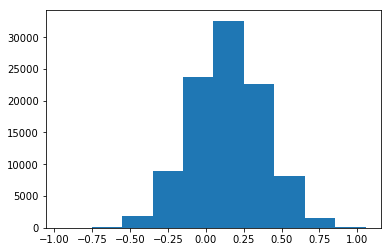

In [7]:
# question 3
niter = 10**5
sir_theta = np.random.normal(loc = 0, scale = 0.25, size = niter)
ratio = np.exp(5*sir_theta)/np.power(1+np.exp(sir_theta), 5)
w = ratio/np.sum(ratio)
theta_post = np.random.choice(sir_theta, size = niter, replace = True, p = w)
plt.hist(theta_post)

bias_prob3 = np.mean(theta_post > 0)
bias_prob3

> Probabilities are a bit low here. Check solutions.

> 21/25

# Question 3

The goal of this problem is to investigate the role of the proposal distribution in a Metropolis-Hastings algorithm designed to simulate from the posterior distribution of the mixture parameter $\delta$. 

1. Simulate 200 realizations from the mixture distribution:
    $$y_i \sim \delta N(7, 0.5^2) + (1-\delta) N(10, 0.5^2)$$
    with $\delta = 0.7$. Plot a histogram of these data. 
2. Implement a random walk M-H algorithm with proposal $\delta^{\prime} = \delta^{(i)} + \epsilon$ with $\epsilon \sim Unif(-1,1)$. 
3. Reparameterize the problem letting $U = \log\left[\frac{\delta}{1 - \delta}\right]$ and $u^{\prime} = u^{(i)} + \epsilon$. Implement a random walk chain in U-space. 
4. Compare the estimates and convergence behavior of the three algorithms.

In part (1), you are asked to simulate data from a distribution with $\delta$ known. For parts (2)–(3), assume $\delta$ is unknown with prior $\delta \sim Unif( 0,1)$. For parts (2)–(3), provide an appropriate plot and a table summarizing the output of the algorithm. 

To facilitate comparisons, use the same number of iterations, random seed, starting values, and burn-in period for all implementations of the algorithm. 

(array([  8.,  80.,  49.,   3.,   0.,   0.,   1.,  13.,  38.,   8.]),
 array([  6.18968316,   6.64768687,   7.10569057,   7.56369428,
          8.02169798,   8.47970168,   8.93770539,   9.39570909,
          9.85371279,  10.3117165 ,  10.7697202 ]),
 <a list of 10 Patch objects>)

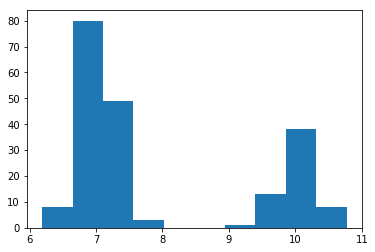

In [8]:
# Write answer here
# question 1
np.random.seed(42)

n_sample = 200
delta = 0.7
flag = np.random.uniform(0,1,n_sample) < 0.7
y = flag*np.random.normal(loc=7, scale=0.25, size=n_sample) \
    +(1-flag)*np.random.normal(loc=10, scale=0.25, size=n_sample)
plt.hist(y)

> Nice job simulating the data:
> 5/5

In [9]:
from scipy.stats import distributions
norm = distributions.norm.pdf

def calc_posterior(delta, y):
    prob = delta*norm(y, loc=7, scale=0.25) + (1-delta)*norm(y, loc=10, scale=0.25)
    return np.sum(np.log(prob))

def metropolis(n_iterations, initial_values, param):               
    # Initialize trace for parameters
    trace = np.empty(n_iterations+1)
    
    # Set initial values
    trace[0] = initial_values
        
    # Calculate joint posterior for initial values
    if param == 'original':
        current_log_prob = calc_posterior(initial_values, y)
    elif param == 'uspace':
        current_log_prob = calc_posterior(np.exp(initial_values)/(1+np.exp(initial_values)), y)
    
    # Initialize acceptance counts
    accepted = 0
    
    for i in range(n_iterations):
    
        if not i%1000: print('Iteration %i' % i)
    
        # Grab current parameter values
        current_params = trace[i]
        
        error = np.random.uniform(-1,1)
        proposed = current_params + error
    
        # Calculate log posterior with proposed value
        if param == 'original':
            proposed_log_prob = calc_posterior(proposed, y)
        elif param == 'uspace':
            proposed_log_prob = calc_posterior(np.exp(proposed)/(1+np.exp(proposed)), y)
        
        # Log-acceptance rate
        alpha = proposed_log_prob - current_log_prob

        # Sample a uniform random variate
        u = np.random.random()

        # Test proposed value
        if np.log(u) < alpha:
            # Accept
            trace[i+1] = proposed
            current_log_prob = proposed_log_prob
            accepted += 1
        else:
            # Reject
            trace[i+1] = trace[i]
    return trace, accepted

Iteration 0
Iteration 1000
Iteration 2000
Iteration 3000
Iteration 4000
Iteration 5000
Iteration 6000
Iteration 7000
Iteration 8000
Iteration 9000
The estimated delta is  0.6939 and the number of accepted is  519


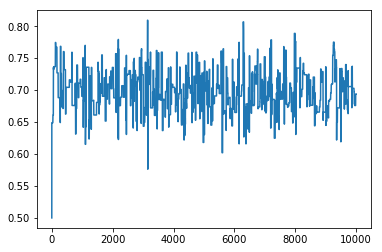

In [10]:
# question 2
trace_1, accepted_1 = metropolis(10**4, 0.5, 'original')
plt.plot(trace_1)
print("The estimated delta is {0: .4f} and the number of accepted is {1: }"
          .format(trace_1[-1], accepted_1))

Iteration 0
Iteration 1000
Iteration 2000
Iteration 3000
Iteration 4000
Iteration 5000
Iteration 6000
Iteration 7000
Iteration 8000
Iteration 9000
The estimated delta is  0.7119 and the number of accepted is  2561


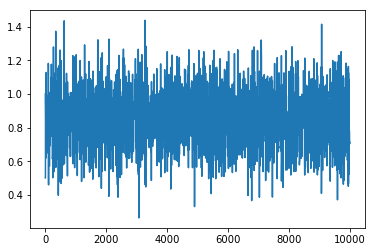

In [11]:
# question 3
trace_2, accpeted_2 = metropolis(10**4, 0.5, 'uspace')
plt.plot(trace_2)
print("The estimated delta is {0: .4f} and the number of accepted is {1: }"
          .format(trace_2[-1], accpeted_2))

4: We obtain a more acuurate estimated value for $\delta$ but with a low acceptance number. However, the transformation in the U-space allows us to accept at more times than the original model.

> Good: 25/25

# Question 4

Carlin (1992) considers a Bayesian approach to meta-analysis, and includes the following examples of 22 trials of beta-blockers to prevent mortality after myocardial infarction. These data are given below.

In one possible random effects model we assume the true baseline mean (on a log-odds scale) $m_i$ in a trial $i$
is drawn from some population distribution. Let $r^C_i$ denote number of events in the control group in trial $i$, and $r^T_i$ denote events under active treatment in trial $i$. Our model is:

$$\begin{aligned}
r^C_i &\sim \text{Binomial}\left(p^C_i, n^C_i\right) \\
r^T_i &\sim \text{Binomial}\left(p^T_i, n^T_i\right) \\
\text{logit}\left(p^C_i\right) &= \mu_i \\
\text{logit}\left(p^T_i\right) &= \mu_i + \delta \\
\mu_i &\sim \text{Normal}(m, s).
\end{aligned}$$

In this case, we want to make inferences about the population effect $m$, and the predictive distribution for the effect $\delta_{\text{new}}$ in a new trial. 

This particular model uses a random effect for the population mean, and a fixed effect for the treatment effect. There are 3 other models you could fit to represent all possible combinations of fixed or random effects for these two parameters.

Build all 4 models to estimate the treatment effect in PyMC3 and 

1. use convergence diagnostics to check for convergence in each model 
2. use posterior predictive checks to compare the fit of the models
3. use DIC to compare the models as approximations of the true generating model

Which model would you select and why?

In [12]:
r_t_obs = [3, 7, 5, 102, 28, 4, 98, 60, 25, 138, 64, 45, 9, 57, 25, 33, 28, 8, 6, 32, 27, 22]
n_t_obs = [38, 114, 69, 1533, 355, 59, 945, 632, 278,1916, 873, 263, 291, 858, 154, 207, 251, 151, 174, 209, 391, 680]
r_c_obs = [3, 14, 11, 127, 27, 6, 152, 48, 37, 188, 52, 47, 16, 45, 31, 38, 12, 6, 3, 40, 43, 39]
n_c_obs = [39, 116, 93, 1520, 365, 52, 939, 471, 282, 1921, 583, 266, 293, 883, 147, 213, 122, 154, 134, 218, 364, 674]
N = len(n_c_obs)

Model 1
$$\begin{aligned}
\text{logit}\left(p^C_i\right) &= \mu_i \\
\text{logit}\left(p^T_i\right) &= \mu_i + \delta \\
\mu_i &\sim \text{Normal}(m, s).
\end{aligned}$$

Model 2
$$\begin{aligned}
\text{logit}\left(p^C_i\right) &= \mu_i \\
\text{logit}\left(p^T_i\right) &= \mu_i + \delta_i \\
\mu_i &\sim \text{Normal}(m, s) \\
\delta_i &\sim \text{Normal}(r, t).
\end{aligned}$$

Model 3
$$\begin{aligned}
\text{logit}\left(p^C_i\right) &= \mu \\
\text{logit}\left(p^T_i\right) &= \mu + \delta_i \\
\delta_i &\sim \text{Normal}(r, t).
\end{aligned}$$

Model 4
$$\begin{aligned}
\text{logit}\left(p^C_i\right) &= \mu \\
\text{logit}\left(p^T_i\right) &= \mu + \delta.
\end{aligned}$$

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|█████████████████████████████████████| 5500/5500 [00:08<00:00, 678.25it/s]


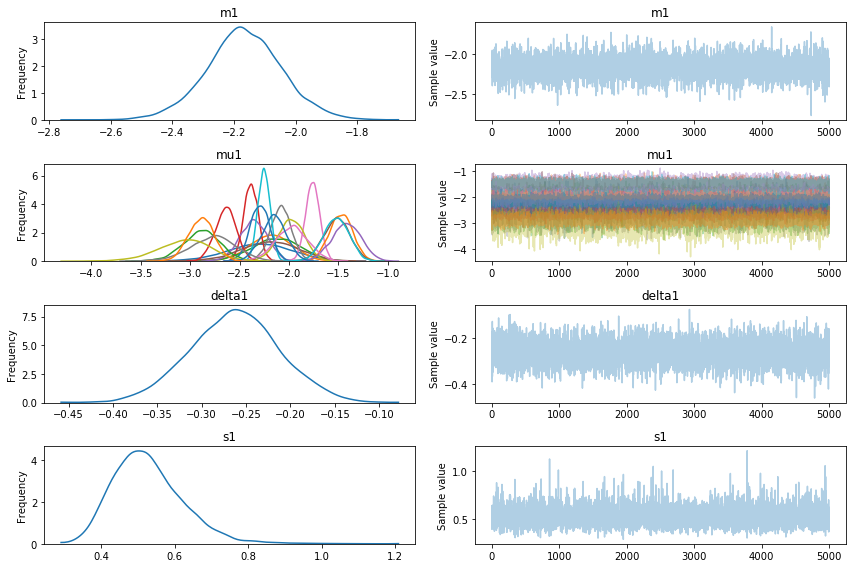

In [13]:
# model 1
with pm.Model() as meta_analysis1:
    
    # priors
    m1 = pm.Normal('m1', mu=0, sd=1)
    s1 = pm.HalfCauchy('s1', 1)

    mu1 = pm.Normal('mu1', mu=m1, sd=s1, shape = N)
    delta1 = pm.Normal('delta1', mu=0, sd=1)

    p_c1 = pm.math.invlogit(mu1)
    p_t1 = pm.math.invlogit(mu1+delta1)

    r_c1 = pm.Binomial('r_c1', n_c_obs, p_c1, observed=r_c_obs)
    r_t1 = pm.Binomial('r_t1', n_t_obs, p_t1, observed=r_t_obs)
    
    trace1 = pm.sample(5000)
    pm.traceplot(trace1)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|████████████████████████████████████▉| 5495/5500 [00:23<00:00, 237.06it/s]C:\Users\Rui\AppData\Local\conda\conda\envs\myenv\lib\site-packages\pymc3\step_methods\hmc\nuts.py:467: UserWarning: Chain 0 contains 64 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|█████████████████████████████████████| 5500/5500 [00:23<00:00, 237.03it/s]


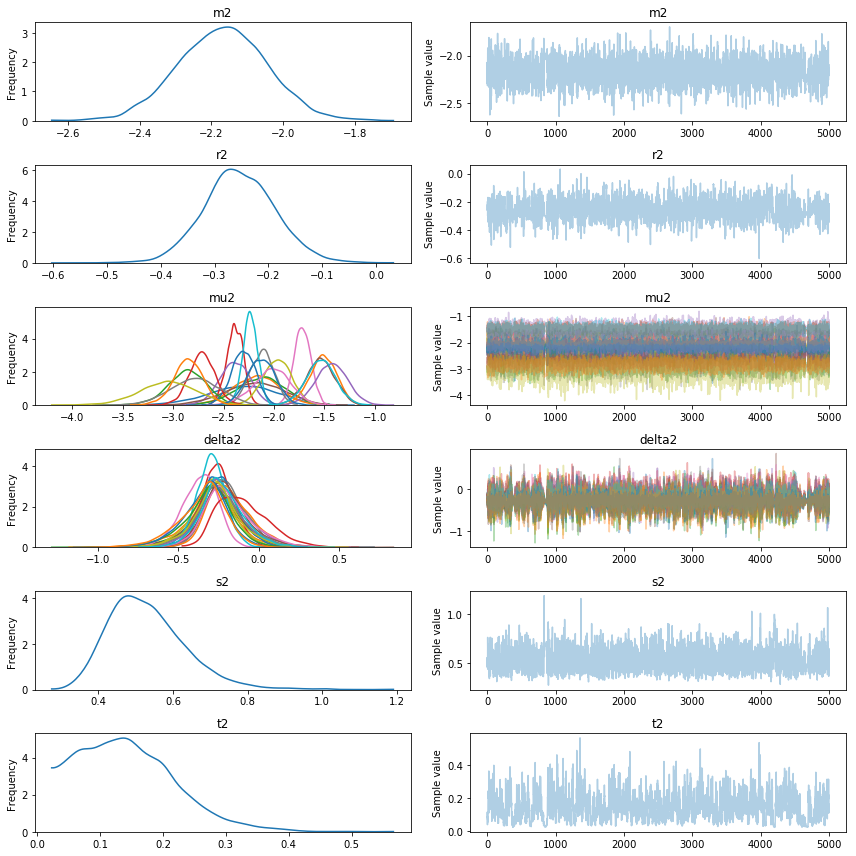

In [14]:
# model 2
with pm.Model() as meta_analysis2:
    
    # priors
    m2 = pm.Normal('m2', mu=0, sd=1)
    s2 = pm.HalfCauchy('s2', 1)
    r2 = pm.Normal('r2', mu=0, sd=1)
    t2 = pm.HalfCauchy('t2', 1)

    mu2 = pm.Normal('mu2', mu=m2, sd=s2, shape = N)
    delta2 = pm.Normal('delta2', mu=r2, sd=t2, shape = N)

    p_c2 = pm.math.invlogit(mu2)
    p_t2 = pm.math.invlogit(mu2+delta2)

    r_c2 = pm.Binomial('r_c2', n_c_obs, p_c2, observed=r_c_obs)
    r_t2 = pm.Binomial('r_t2', n_t_obs, p_t2, observed=r_t_obs)
    
    trace2 = pm.sample(5000)
    pm.traceplot(trace2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|█████████████████████████████████████| 5500/5500 [00:09<00:00, 578.45it/s]


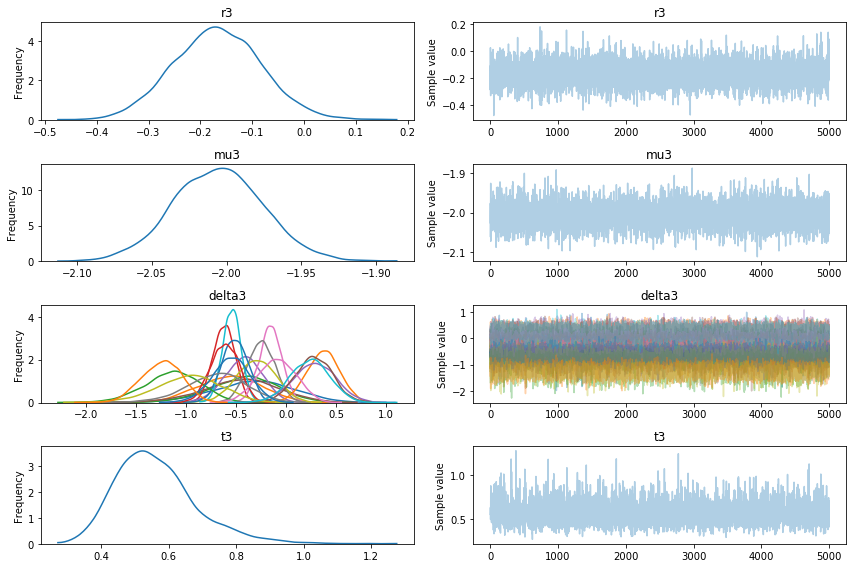

In [15]:
# model 3
with pm.Model() as meta_analysis3:
    
    # priors
    r3 = pm.Normal('r3', mu=0, sd=0.1)
    t3 = pm.HalfCauchy('t3', 1)
    
    mu3 = pm.Normal('mu3', mu=0, sd=0.1)
    delta3 = pm.Normal('delta3', mu=r3, sd=t3, shape = N)

    p_c3 = pm.math.invlogit(mu3)
    p_t3 = pm.math.invlogit(delta3+mu3)

    r_c3 = pm.Binomial('r_c3', n_c_obs, p_c3, observed=r_c_obs)
    r_t3 = pm.Binomial('r_t3', n_t_obs, p_t3, observed=r_t_obs)
    
    trace3 = pm.sample(5000)
    pm.traceplot(trace3)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|████████████████████████████████████| 5500/5500 [00:03<00:00, 1375.29it/s]


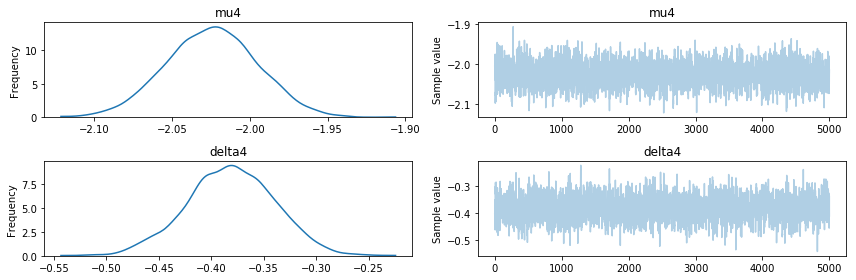

In [16]:
# model 4
with pm.Model() as meta_analysis4:    

    mu4 = pm.Normal('mu4', mu=0, sd=0.1)
    delta4 = pm.Normal('delta4', mu=0, sd=0.1)

    p_c4 = pm.math.invlogit(mu4)
    p_t4 = pm.math.invlogit(mu4+delta4)

    r_c4 = pm.Binomial('r_c4', n_c_obs, p_c4, observed=r_c_obs)
    r_t4 = pm.Binomial('r_t4', n_t_obs, p_t4, observed=r_t_obs)
    
    trace4 = pm.sample(5000)
    pm.traceplot(trace4)

## 1. use convergence diagnostics to check for convergence in each model 

### model 1

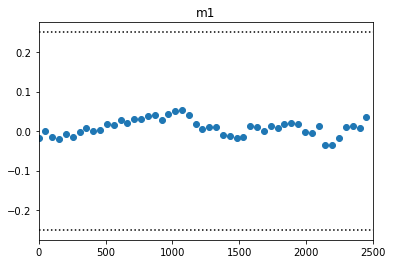

In [17]:
z1 = pm.geweke(trace1, intervals=50)
plt.scatter(*z1['m1'].T)
plt.hlines([-0.25,0.25], 0, 2500, linestyles='dotted')
plt.xlim(0, 2500)
plt.title('m1')

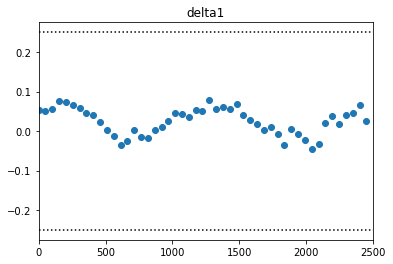

In [18]:
plt.scatter(*z1['delta1'].T)
plt.hlines([-0.25,0.25], 0, 2500, linestyles='dotted')
plt.xlim(0, 2500)
plt.title('delta1')

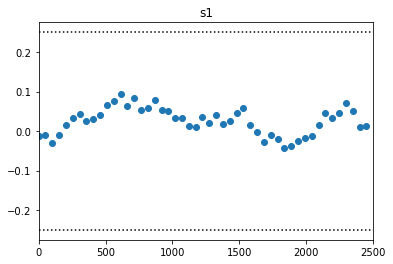

In [19]:
plt.scatter(*z1['s1'].T)
plt.hlines([-0.25,0.25], 0, 2500, linestyles='dotted')
plt.xlim(0, 2500)
plt.title('s1')

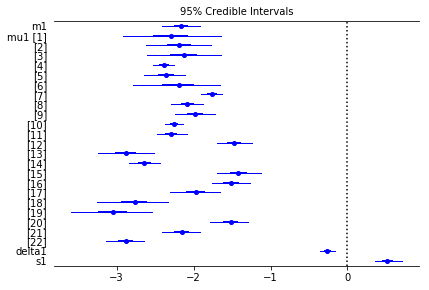

In [20]:
pm.forestplot(trace1)

### model 2

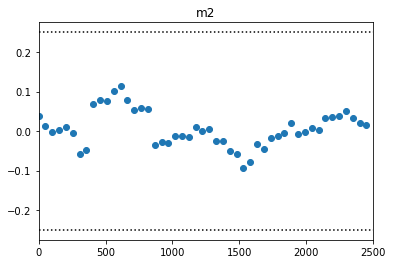

In [21]:
z2 = pm.geweke(trace2, intervals=50)
plt.scatter(*z2['m2'].T)
plt.hlines([-0.25,0.25], 0, 2500, linestyles='dotted')
plt.xlim(0, 2500)
plt.title('m2')

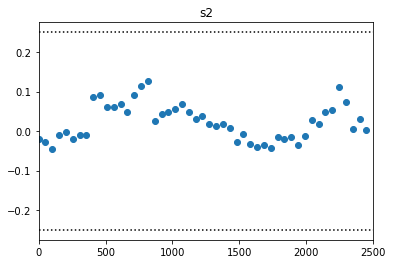

In [22]:
plt.scatter(*z2['s2'].T)
plt.hlines([-0.25,0.25], 0, 2500, linestyles='dotted')
plt.xlim(0, 2500)
plt.title('s2')

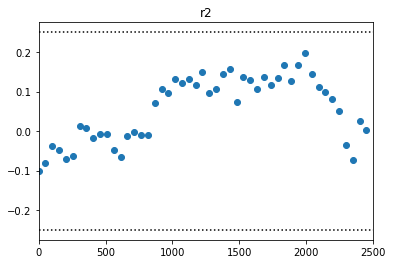

In [23]:
plt.scatter(*z2['r2'].T)
plt.hlines([-0.25,0.25], 0, 2500, linestyles='dotted')
plt.xlim(0, 2500)
plt.title('r2')

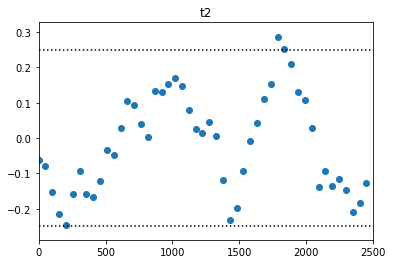

In [24]:
plt.scatter(*z2['t2'].T)
plt.hlines([-0.25,0.25], 0, 2500, linestyles='dotted')
plt.xlim(0, 2500)
plt.title('t2')

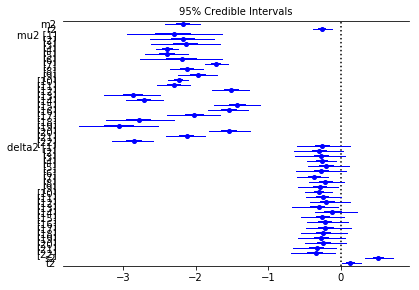

In [25]:
pm.forestplot(trace2)

### model 3

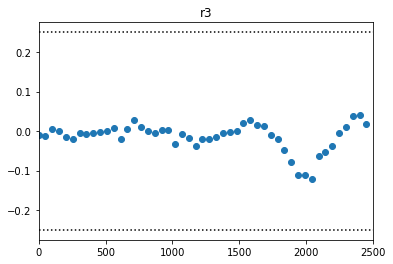

In [26]:
z3 = pm.geweke(trace3, intervals=50)
plt.scatter(*z3['r3'].T)
plt.hlines([-0.25,0.25], 0, 2500, linestyles='dotted')
plt.xlim(0, 2500)
plt.title('r3')

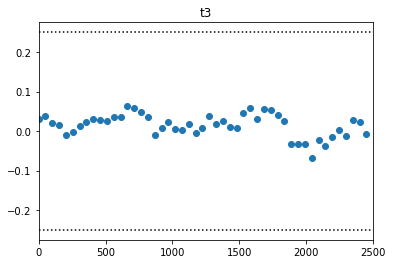

In [27]:
plt.scatter(*z3['t3'].T)
plt.hlines([-0.25,0.25], 0, 2500, linestyles='dotted')
plt.xlim(0, 2500)
plt.title('t3')

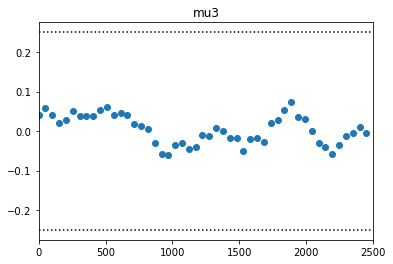

In [28]:
plt.scatter(*z3['mu3'].T)
plt.hlines([-0.25,0.25], 0, 2500, linestyles='dotted')
plt.xlim(0, 2500)
plt.title('mu3')

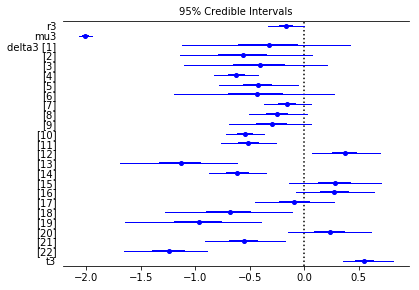

In [29]:
pm.forestplot(trace3)

### model 4

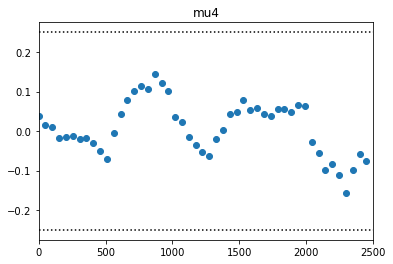

In [30]:
z4 = pm.geweke(trace4, intervals=50)
plt.scatter(*z4['mu4'].T)
plt.hlines([-0.25,0.25], 0, 2500, linestyles='dotted')
plt.xlim(0, 2500)
plt.title('mu4')

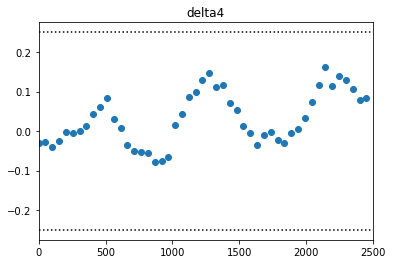

In [31]:
plt.scatter(*z4['delta4'].T)
plt.hlines([-0.25,0.25], 0, 2500, linestyles='dotted')
plt.xlim(0, 2500)
plt.title('delta4')

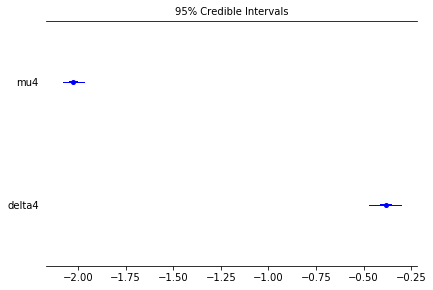

In [32]:
pm.forestplot(trace4)

## 2. use posterior predictive checks to compare the fit of the models


### model 1

In [33]:
ppc1 = pm.sample_ppc(trace1, samples=500, model=meta_analysis1)

100%|██████████████████████████████████████| 500/500 [00:00<00:00, 1467.96it/s]


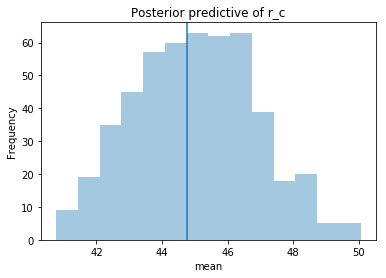

In [34]:
ax = plt.subplot()
sns.distplot([n.mean() for n in ppc1['r_c1']], kde=False, ax=ax)
ax.axvline(np.mean(r_c_obs))
ax.set(title='Posterior predictive of r_c', xlabel='mean', ylabel='Frequency')

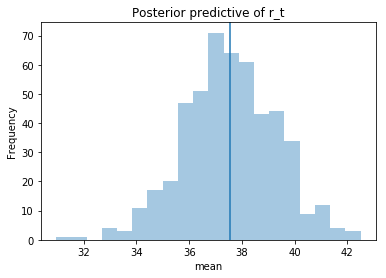

In [35]:
ax = plt.subplot()
sns.distplot([n.mean() for n in ppc1['r_t1']], kde=False, ax=ax)
ax.axvline(np.mean(r_t_obs))
ax.set(title='Posterior predictive of r_t', xlabel='mean', ylabel='Frequency')

### model 2

In [36]:
ppc2 = pm.sample_ppc(trace2, samples=500, model=meta_analysis2)

100%|██████████████████████████████████████| 500/500 [00:00<00:00, 1483.13it/s]


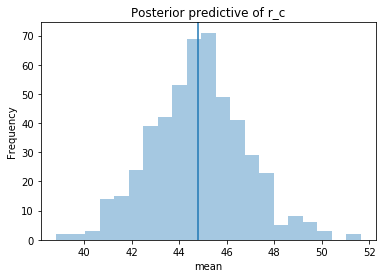

In [37]:
ax = plt.subplot()
sns.distplot([n.mean() for n in ppc2['r_c2']], kde=False, ax=ax)
ax.axvline(np.mean(r_c_obs))
ax.set(title='Posterior predictive of r_c', xlabel='mean', ylabel='Frequency')

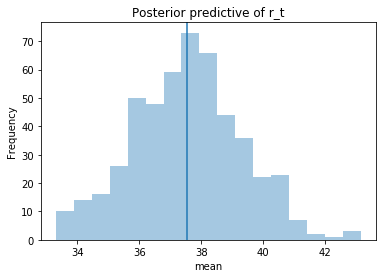

In [38]:
ax = plt.subplot()
sns.distplot([n.mean() for n in ppc2['r_t2']], kde=False, ax=ax)
ax.axvline(np.mean(r_t_obs))
ax.set(title='Posterior predictive of r_t', xlabel='mean', ylabel='Frequency')

### model 3

In [39]:
ppc3 = pm.sample_ppc(trace3, samples=500, model=meta_analysis3)

100%|██████████████████████████████████████| 500/500 [00:00<00:00, 1463.64it/s]


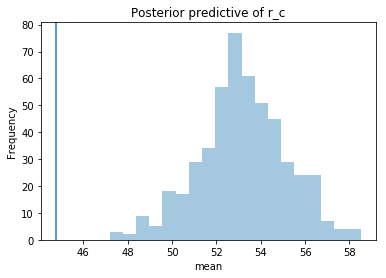

In [40]:
ax = plt.subplot()
sns.distplot([n.mean() for n in ppc3['r_c3']], kde=False, ax=ax)
ax.axvline(np.mean(r_c_obs))
ax.set(title='Posterior predictive of r_c', xlabel='mean', ylabel='Frequency')

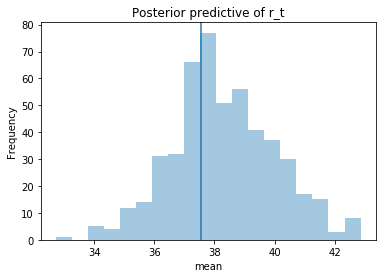

In [41]:
ax = plt.subplot()
sns.distplot([n.mean() for n in ppc3['r_t3']], kde=False, ax=ax)
ax.axvline(np.mean(r_t_obs))
ax.set(title='Posterior predictive of r_t', xlabel='mean', ylabel='Frequency')

### model 4

In [42]:
ppc4 = pm.sample_ppc(trace4, samples=500, model=meta_analysis4)

100%|██████████████████████████████████████| 500/500 [00:00<00:00, 1455.93it/s]


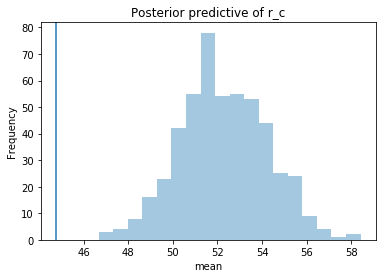

In [43]:
ax = plt.subplot()
sns.distplot([n.mean() for n in ppc4['r_c4']], kde=False, ax=ax)
ax.axvline(np.mean(r_c_obs))
ax.set(title='Posterior predictive of r_c', xlabel='mean', ylabel='Frequency')

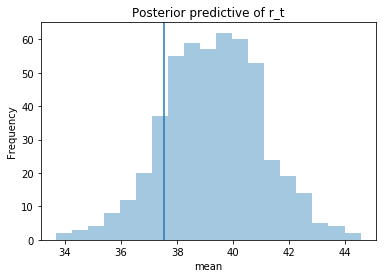

In [44]:
ax = plt.subplot()
sns.distplot([n.mean() for n in ppc4['r_t4']], kde=False, ax=ax)
ax.axvline(np.mean(r_t_obs))
ax.set(title='Posterior predictive of r_t', xlabel='mean', ylabel='Frequency')

## 3. use DIC to compare the models as approximations of the true generating model

### model 1

In [45]:
dic1 = pm.stats.dic(trace1, model = meta_analysis1)
dic1

333.1452563588839

### model 2

In [46]:
dic2 = pm.stats.dic(trace2, model = meta_analysis2)
dic2

324.00063718112904

### model 3

In [47]:
dic3 = pm.stats.dic(trace3, model = meta_analysis3)
dic3

915.17274395072832

### model 4

In [48]:
dic4 = pm.stats.dic(trace4, model = meta_analysis4)
dic4

975.52743905565671

### Which model would you select and why?

1. From the DIC values comparison, we should not choose model 3 and model 4.
2. From the analysis of Goodness of Fit, $r_c$ in model 3 and model 4 is not well estimated from the sampled histogram. 
3. Model 2 adds random effects to $\mu$ and $\delta$. From convergence diagnostics, the estimated parameters are very unstable in the end of iteration loops, indicating that the model might be not appropriate for these data. 

Therefore, we should choose the original model:

$$\begin{aligned}
r^C_i &\sim \text{Binomial}\left(p^C_i, n^C_i\right) \\
r^T_i &\sim \text{Binomial}\left(p^T_i, n^T_i\right) \\
\text{logit}\left(p^C_i\right) &= \mu_i \\
\text{logit}\left(p^T_i\right) &= \mu_i + \delta \\
\mu_i &\sim \text{Normal}(m, s).
\end{aligned}$$

> Nice job: 25/25

> Total Homework 2 score: 91/100